Goal of this notebook to test several classifiers on the data set with different features 

And beforehand i want to thank Jose Portilla for his magnificent "Python for Data Science and Machine Learning" course on Udemy , which helped me to dive into ML =)

### Let's begin

First of all neccesary imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import string
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
# from nltk.stem import SnowballStemmerSnowballStemmer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

Let's read the data from csv file

In [2]:
sms = pd.read_csv('../data/sms-spam.csv',delimiter=',',encoding='latin-1')

sms.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Now drop "unnamed" columns and rename v1 and v2 to "label" and "message"

In [3]:
sms = sms.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
sms = sms.rename(columns = {'v1':'label','v2':'message'})

Let's look into our data

In [4]:
sms.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

Intresting that "Sorry, I'll call later" appears only 30 times here =)

Now let's create new feature "message length" and plot it to see if it's of any interest

In [5]:
sms['length'] = sms['message'].apply(len)
sms.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10831f128>,
      dtype=object)

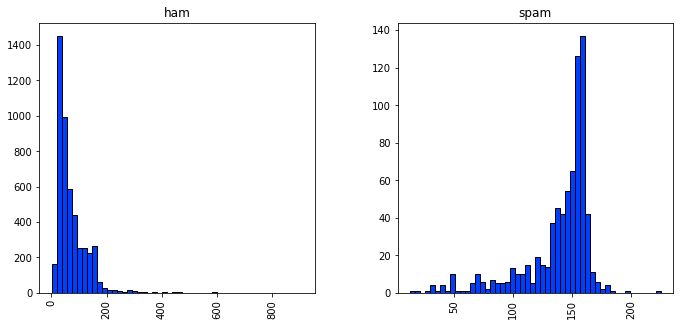

In [6]:
mpl.rcParams['patch.force_edgecolor'] = True
plt.style.use('seaborn-bright')
sms.hist(column='length', by='label', bins=50,figsize=(11,5))

Looks like the lengthy is the message, more likely it is a spam. Let's not forget this

### Text processing and vectorizing our meddages

Let's create new data frame. We'll need a copy later on

In [7]:
text_feat = sms['message'].copy()

Now define our tex precessing function. It will remove any punctuation and stopwords aswell.

In [8]:
def text_process(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = [word for word in text.split() if word.lower() not in stopwords.words('english')]
    
    return " ".join(text)

In [9]:
text_feat = text_feat.apply(text_process)

In [10]:
vectorizer = TfidfVectorizer("english")

In [11]:
features = vectorizer.fit_transform(text_feat)

In [12]:
labels = LabelEncoder().fit_transform(sms['label'])
labels = labels.reshape(-1,1)

In [13]:
text_feat.shape

(5572,)

In [14]:
features.shape

(5572, 9403)

###  Classifiers and predictions

First of all let's split our features to test and train set

In [15]:
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.3, random_state=111)

Now let's import bunch of classifiers, initialize them and make a dictionary to itereate through

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [17]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier(n_neighbors=49)
mnb = MultinomialNB(alpha=0.2)
dtc = DecisionTreeClassifier(min_samples_split=7, random_state=111)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=31, random_state=111)
abc = AdaBoostClassifier(n_estimators=62, random_state=111)
bc = BaggingClassifier(n_estimators=9, random_state=111)
etc = ExtraTreesClassifier(n_estimators=9, random_state=111)

Parametres are based on notebook:
[Spam detection Classifiers hyperparameter tuning][1]


  [1]: https://www.kaggle.com/muzzzdy/d/uciml/sms-spam-collection-dataset/spam-detection-classifiers-hyperparameter-tuning/

In [18]:
clfs = {'SVC' : svc,'KN' : knc, 'NB': mnb, 'DT': dtc, 'LR': lrc, 'RF': rfc, 'AdaBoost': abc, 'BgC': bc, 'ETC': etc}

Let's make functions to fit our classifiers and make predictions

In [19]:
def train_classifier(clf, feature_train, labels_train):    
    clf.fit(feature_train, labels_train)

In [20]:
def predict_labels(clf, features):
    return (clf.predict(features))

Now iterate through classifiers and save the results

In [21]:
import time

In [22]:
pred_scores = []
for k,v in clfs.items():
    since = time.time()
   
    train_classifier(v, features_train, labels_train)
    time_elapsed = time.time() - since
    
    pred = predict_labels(v,features_test)
    pred_scores.append((k, [accuracy_score(labels_test,pred), '{:.0f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60)]))

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from ipykernel import kernelapp as app
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was ex

In [23]:
pred_scores

[('SVC', [0.9772727272727273, '0m 0.3694s']),
 ('KN', [0.9252392344497608, '0m 0.0020s']),
 ('NB', [0.9850478468899522, '0m 0.0048s']),
 ('DT', [0.9569377990430622, '0m 0.1838s']),
 ('LR', [0.9383971291866029, '0m 0.0149s']),
 ('RF', [0.9760765550239234, '0m 1.3317s']),
 ('AdaBoost', [0.9635167464114832, '0m 2.6722s']),
 ('BgC', [0.9659090909090909, '0m 1.1860s']),
 ('ETC', [0.9706937799043063, '0m 1.0054s'])]

In [24]:
df = pd.DataFrame.from_items(pred_scores,orient='index', columns=['Score', 'Training Time (s)'])
df

,Score,Training Time (s)
SVC,0.977273,0m 0.3694s
KN,0.925239,0m 0.0020s
NB,0.985048,0m 0.0048s
DT,0.956938,0m 0.1838s
LR,0.938397,0m 0.0149s
RF,0.976077,0m 1.3317s
AdaBoost,0.963517,0m 2.6722s
BgC,0.965909,0m 1.1860s
ETC,0.970694,0m 1.0054s


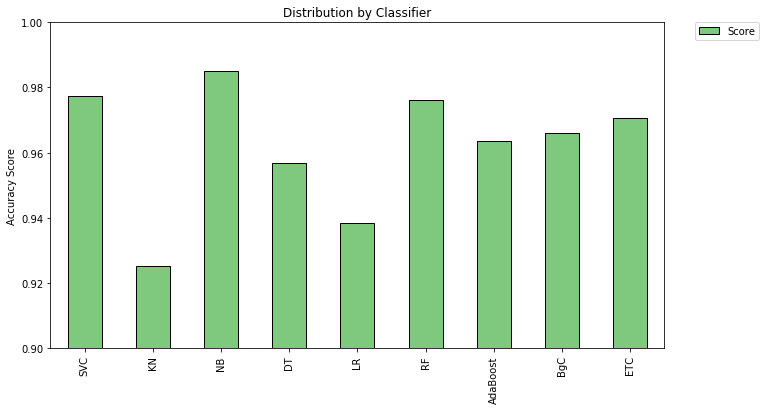

In [25]:
df.plot(kind='bar', ylim=(0.9,1.0), figsize=(11,6), align='center', colormap="Accent")
plt.xticks(np.arange(9), df.index)
plt.ylabel('Accuracy Score')
plt.title('Distribution by Classifier')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Looks like ensemble classifiers are not doing as good as expected.

### Voting classifier

We are using ensemble algorithms here, but what about ensemble of ensembles? Will it beat NB?

In [26]:
from sklearn.ensemble import VotingClassifier

In [27]:
eclf = VotingClassifier(estimators=[('BgC', bc), ('ETC', etc), ('RF', rfc), ('Ada', abc)], voting='soft')

In [28]:
eclf.fit(features_train,labels_train)

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


VotingClassifier(estimators=[('BgC', BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=9, n_jobs=1, oob_score=False, random_state=111,
         verbose=0, warm_start=False)), ('ETC', ExtraTreesClassifier(bootstrap=False,...hm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=62, random_state=111))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [29]:
pred = eclf.predict(features_test)

/Users/alex/anaconda/envs/gc/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [30]:
print(accuracy_score(labels_test,pred))

0.9760765550239234


Better but nope.

### RNN
Define the RNN structure.

In [67]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [68]:
max_words = features_train.shape[0]
max_len = features_train.shape[1]

In [69]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 9403)              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 9403, 50)          195000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [ ]:
since = time.time()
   
model.fit(features_train,labels_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

time_elapsed = time.time() - since

Train on 3120 samples, validate on 780 samples
Epoch 1/10
 512/3120 [===>..........................] - ETA: 56:09 - loss: 0.6526 - acc: 0.7461  

In [ ]:
print('Training complete in {:.0f}m {:.4f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 

In [32]:
accr = model.evaluate(features_test,labels_test)

1536/1672 [==========================>...] - ETA: 5s

KeyboardInterrupt: 

In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

### gcForest

In [31]:
import sys
sys.path.append("..") 
from gcforest.gcforest import GCForest
from gcforest.utils.config_utils import load_json

In [32]:
def get_toy_config():
    config = {}
    ca_config = {}
    ca_config["random_state"] = 111
    ca_config["max_layers"] = 10
    ca_config["early_stopping_rounds"] = 3
    ca_config["n_classes"] = 2
    ca_config["estimators"] = []
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 31, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "RandomForestClassifier", "n_estimators": 31, "n_jobs": -1})
    ca_config["estimators"].append({"n_folds": 5, "type": "MultinomialNB", "alpha": 0.2})
    ca_config["estimators"].append({"n_folds": 5, "type": "MultinomialNB", "alpha": 0.2})

    config["cascade"] = ca_config
    return config

In [33]:
import time

In [34]:
config = get_toy_config()
gc = GCForest(config)

# features_train 为 ndarray，labels_train 维度为 (n_samples, )，而不是(n_samples, 1)
features_train = features_train.toarray()
labels_train = labels_train.reshape(-1)

since = time.time()
gc.fit_transform(features_train, labels_train)

time_elapsed = time.time() - since

# gc.fit_transform(features_train, labels_train, features_test, labels_test)

[ 2019-04-22 20:23:04,409][cascade_classifier.fit_transform] X_groups_train.shape=[(3900, 9403)],y_train.shape=(3900,),X_groups_test.shape=no_test,y_test.shape=no_test
[ 2019-04-22 20:23:04,700][cascade_classifier.fit_transform] group_dims=[9403]
[ 2019-04-22 20:23:04,701][cascade_classifier.fit_transform] group_starts=[0]
[ 2019-04-22 20:23:04,702][cascade_classifier.fit_transform] group_ends=[9403]
[ 2019-04-22 20:23:04,703][cascade_classifier.fit_transform] X_train.shape=(3900, 9403),X_test.shape=(0, 9403)
[ 2019-04-22 20:23:05,012][cascade_classifier.fit_transform] [layer=0] look_indexs=[0], X_cur_train.shape=(3900, 9403), X_cur_test.shape=(0, 9403)
[ 2019-04-22 20:23:09,541][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 5_folds.train_0.predict)=96.67%
[ 2019-04-22 20:23:13,353][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 - 5_folds.train_1.predict)=95.00%
[ 2019-04-22 20:23:16,917][kfold_wrapper.log_eval_metrics] Accuracy(layer_0 - estimator_0 

[ 2019-04-22 20:24:26,143][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_3.predict)=98.72%
[ 2019-04-22 20:24:27,936][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_4.predict)=98.72%
[ 2019-04-22 20:24:27,937][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_1 - 5_folds.train_cv.predict)=98.41%
[ 2019-04-22 20:24:28,178][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_0.predict)=99.36%
[ 2019-04-22 20:24:28,418][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_1.predict)=98.08%
[ 2019-04-22 20:24:28,656][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_2.predict)=98.21%
[ 2019-04-22 20:24:28,892][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_3.predict)=98.21%
[ 2019-04-22 20:24:29,130][kfold_wrapper.log_eval_metrics] Accuracy(layer_2 - estimator_2 - 5_folds.train_4.predict)=98.46%
[ 2019-

[ 2019-04-22 20:25:14,482][kfold_wrapper.log_eval_metrics] Accuracy(layer_4 - estimator_3 - 5_folds.train_cv.predict)=98.44%
[ 2019-04-22 20:25:14,483][cascade_classifier.calc_accuracy] Accuracy(layer_4 - train.classifier_average)=98.44%
[ 2019-04-22 20:25:14,484][cascade_classifier.fit_transform] [Result][Optimal Level Detected] opt_layer_num=2, accuracy_train=98.46%, accuracy_test=0.00%


In [35]:
print('Training complete in {:.0f}m {:.4f}s'.format(
        time_elapsed // 60, time_elapsed % 60)) 

Training complete in 2m 10.1454s


In [37]:
pred = predict_labels(gc,features_test.toarray())
print(accuracy_score(labels_test,pred))

[ 2019-04-22 20:26:01,843][cascade_classifier.transform] X_groups_test.shape=[(1672, 9403)]
[ 2019-04-22 20:26:01,976][cascade_classifier.transform] group_dims=[9403]
[ 2019-04-22 20:26:01,977][cascade_classifier.transform] X_test.shape=(1672, 9403)
[ 2019-04-22 20:26:02,071][cascade_classifier.transform] [layer=0] look_indexs=[0], X_cur_test.shape=(1672, 9403)
[ 2019-04-22 20:26:03,805][cascade_classifier.transform] [layer=1] look_indexs=[0], X_cur_test.shape=(1672, 9411)


0.9880382775119617


In [38]:
# pred_scores.append((k, [accuracy_score(labels_test,pred), '{:.0f}m {:.4f}s'.format(time_elapsed // 60, time_elapsed % 60)]))

In [39]:
import pickle
# dump
with open("../pkl/sms-gc.pkl", "wb") as f:
    pickle.dump(gc, f, pickle.HIGHEST_PROTOCOL)
    
# # load
# with open("../pkl/2018_gc.pkl", "rb") as f:
#     gc = pickle.load(f)

### Final verdict - gcForest is your friend in spam detection.